# Hidden Markov Model

In [54]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from hmmlearn import hmm 

# HMM Model on HSI Close Price

# Data Collection

In [4]:
ticker = '^HSI'
start = '2000-01-01'
end = '2024-08-23'
freq = '1d'

In [5]:
data_df = yf.download(ticker, start = start, end = end ,interval = freq)

[*********************100%***********************]  1 of 1 completed


In [6]:
data_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,17057.699219,17426.160156,17057.699219,17369.630859,17369.630859,0
2000-01-04,17303.000000,17303.000000,16933.519531,17072.820312,17072.820312,0
2000-01-05,16608.550781,16608.550781,15688.490234,15846.719727,15846.719727,0
2000-01-06,15942.070312,15971.030273,14763.969727,15153.230469,15153.230469,0
2000-01-07,15329.339844,15513.889648,15108.750000,15405.629883,15405.629883,0
...,...,...,...,...,...,...
2024-08-16,17286.039062,17473.890625,17255.859375,17430.160156,17430.160156,2551716800
2024-08-19,17569.660156,17685.859375,17547.650391,17569.570312,17569.570312,2361570600
2024-08-20,17661.689453,17661.689453,17449.990234,17511.080078,17511.080078,1961800000


In [7]:
close_df = data_df['Close']

In [8]:
close_df

Date
2000-01-03    17369.630859
2000-01-04    17072.820312
2000-01-05    15846.719727
2000-01-06    15153.230469
2000-01-07    15405.629883
                  ...     
2024-08-16    17430.160156
2024-08-19    17569.570312
2024-08-20    17511.080078
2024-08-21    17391.009766
2024-08-22    17641.000000
Name: Close, Length: 6073, dtype: float64

In [11]:
train_test_split_pt = "2019-12-31"
close_train_df = close_df.loc[close_df.index <= train_test_split_pt]
close_test_df = close_df.loc[close_df.index > train_test_split_pt]

# Data Preprocess

In [51]:
train_log_close_diff_df = np.log(close_train_df).diff().dropna()
mean = train_log_close_diff_df.mean(axis = 0)
std = train_log_close_diff_df.std(axis = 0)
norm_train_log_close_diff_df = (train_log_close_diff_df - mean)/std

In [52]:
print("skew: ", scipy.stats.skew(norm_train_log_close_diff_df, axis = 0, bias = True))
print("kurtosis: ", scipy.stats.kurtosis(norm_train_log_close_diff_df, axis = 0, bias = True))
print("skewtest pvalue: ", scipy.stats.skewtest(norm_train_log_close_diff_df).pvalue)
print("kurtosistest pvalue: ", scipy.stats.kurtosistest(norm_train_log_close_diff_df).pvalue)
print("KS-test pvalue: ", scipy.stats.kstest(norm_train_log_close_diff_df,  "norm").pvalue)

mean:  2.0609739653723235e-18
std:  1.0000000000000002
skew:  -0.10384681470615739
kurtosis:  8.099700810350752
skewtest pvalue:  0.0029489626215346574
kurtosistest pvalue:  1.6478071476676528e-168
KS-test pvalue:  6.015732148788219e-23


# QQ Plot

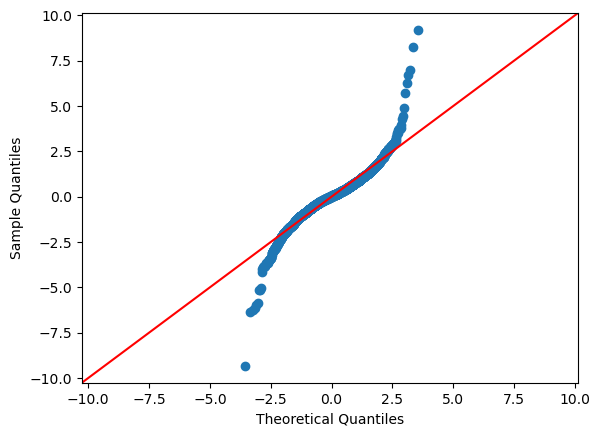

In [53]:
sm.qqplot(norm_train_log_close_diff_df, line = '45')
pylab.show()

# HMM Model Selection Citerion

(1) From empirical experience, the daily log return of market are not independent, and they are autocorrelated

(2) From chart and test above, the standardized daily log return does not follow sample standard normal

Therefore, we may use Guassian to model the daily log return given a hidden state. 

Then, we would use Markov Chain to model the transition between hidden states

# HMM Model

## HMM Model Background

Parameter :

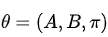

Random Variables : 

X_t : Hidden state at time t

Y_t : Observed value at time t

Initial States Probability:



Transition Matrix : 



Conditional Distribution of Y_t given X_t : 

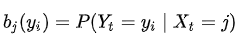

## HMM Model Training - Baum-Welch Algorithm

After the collection of realized observed variables, we can solve for the parameter that maximize the likelihood (probability) of the realzied observation.

Baum-Welch is EM-Algorithm on HMM

### Forward Procedure

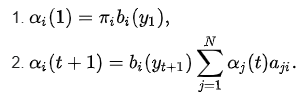

### Backward Procedure

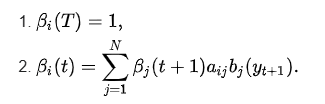

Step E : 

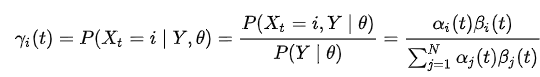

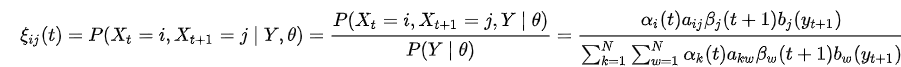

Step M : 

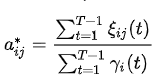

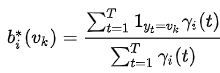


Reference : https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm

Python Package (hmmlearn) : https://hmmlearn.readthedocs.io/en/latest/index.html

### Three Hidden State HMM

In [83]:
# Fit HMM Model
three_state_model = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 200, random_state = 99)
X = train_log_close_diff_df.values
X = X.reshape(-1,1)
three_state_model.fit(X)

GaussianHMM(covariance_type='full', n_components=3, n_iter=200, random_state=99)

In [84]:
three_state_model.startprob_

array([0.00000000e+000, 1.00000000e+000, 1.79125357e-177])

In [85]:
three_state_model.transmat_

array([[6.19115441e-01, 1.35421767e-05, 3.80871017e-01],
       [2.11638890e-04, 9.82199497e-01, 1.75888638e-02],
       [9.74085139e-01, 1.38773814e-02, 1.20374800e-02]])

In [120]:
three_state_model.transmat_[0][:] @ three_state_model.means_

array([0.0001537])

In [86]:
three_state_model.means_

array([[ 0.00088295],
       [-0.00095556],
       [-0.00103169]])

In [87]:
three_state_model.covars_

array([[[7.68088586e-05]],

       [[6.68836731e-04]],

       [[2.00793795e-04]]])

In [88]:
hist_hidden_state = three_state_model.predict(X)

In [96]:
hist_hidden_state

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [106]:
sum((hist_hidden_state ==1)[:-1] * (X[:][1:]>0))

array([2545, 2545, 2545, ...,    0,    0,    0])

In [116]:
total_sum = sum((hist_hidden_state ==1)[:-1] * (X.reshape(1,-1)[0][1:]))

In [117]:
sum((np.sign((X.reshape(1,-1)[0][1:])) == np.sign(total_sum)) * (hist_hidden_state ==1)[:-1])

773

In [114]:
X.reshape(1,-1)[0][1:]

array([-0.07452522, -0.04474878,  0.01651928, ...,  0.01287988,
        0.00332376, -0.00458831])

In [98]:
three_state_model.predict_proba(X)

array([[0.00000000e+000, 1.00000000e+000, 2.92852282e-179],
       [2.46168135e-020, 9.99999961e-001, 3.87414867e-008],
       [8.20735312e-010, 9.99628208e-001, 3.71790798e-004],
       ...,
       [6.78841137e-001, 7.10450417e-004, 3.20448412e-001],
       [7.96479756e-001, 1.38542731e-003, 2.02134816e-001],
       [7.49234478e-001, 2.50377299e-003, 2.48261749e-001]])

# Trading Strategies

Background

We would implement dynamic HMM training method to reflect more up-to-date information

To do so, we would define a hyperparameter W as the lookback window of the information to be fitted for training, we train HMM recursively on each trading date

### Strategy (1) : 

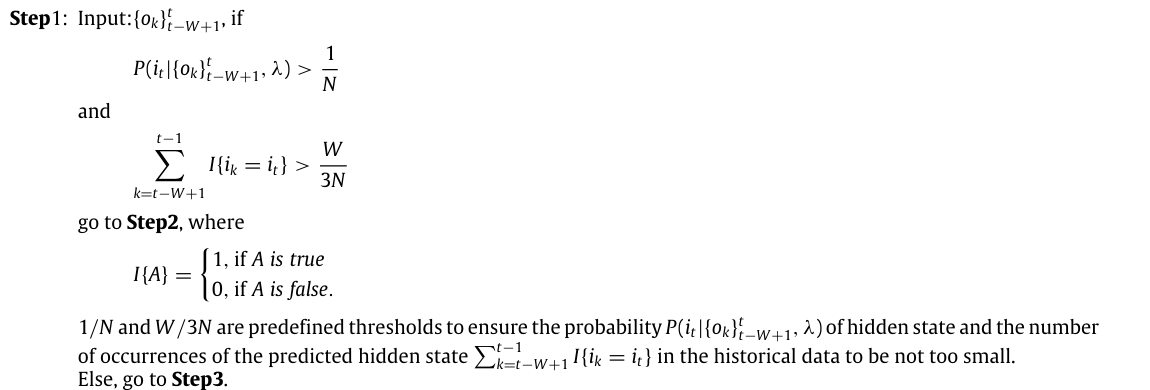



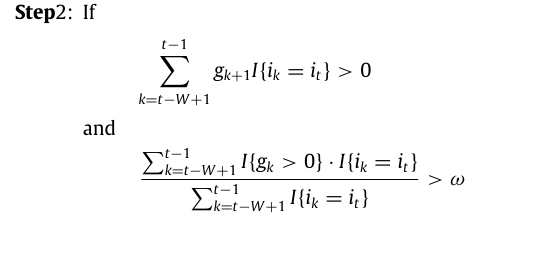

#Typo : g_t+1 instead of g_t

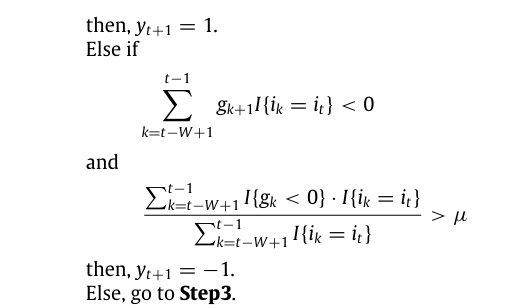

#Typo : g_t+1 instead of g_t

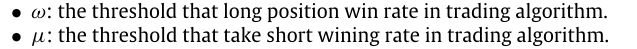



reference : 

High-order Hidden Markov Model for trend prediction in financial time series

https://edisciplinas.usp.br/pluginfile.php/5748773/mod_folder/content/0/Zhang-2019-High-order%20Hidden%20Markov%20Model%20for%20trend%20prediction%20in%20financial%20time%20series.pdf

### Strategy (2)

Instead of using the empirical relation between current hidden state and next day return, we may look at the conditional next day log return given current hidden state

$$E(Y_(t+1)|X_t = i) > \mu$$, then signal = 1

$$E(Y_(t+1)|X_t = i) < -\mu$$, then signal = -1

In [ ]:
class HMM_Trading_Model:
    
    def __init__(self, N, model):
        
        self.data = None
        self.N = N
        self.model = model
        
    def train(self, data):
        
        self.data = data
        self.model.fit(data)
        
    def hist_hidden_state(self):
        
        return self.model.predict(self.data)
        
    def latest_hidden_state(self):
        
        return self.hist_hidden_state()[-1]
    
    def latest_hidden_state_post_prob(self):
        
        return self.model.predict_prob(self.data)[-1, self.hidden_sate]
    
    def transition_matrix(self):
        
        return self.model.transmat_
    
    def cond_observation_mean(self):
        
        return self.model.means_
    
    def strat_one_signal(self, long_win_rate_thres = 0, short_win_rate_thres = 0):
        
        W = len(self.data)
        
        latest_hidden_state_post_prob = self.latest_hidden_state_post_prob()
        occurence_latest_hidden_state = sum(self.latest_hidden_state == self.latest_hidden_state)
        
        # step 1
        
        if latest_hidden_state_post_prob <= 1/N or occurence_latest_hidden_state <= W/(3*N):
            
            return 0
        
        else:
        
        # step 2
        
            total_hist_next_day_observation = sum(self.data.reshape(1,-1)[0][1:] * (self.hist_hidden_state == self.latest_hidden_state)[:-1])
            
            win_rate = sum((np.sign(self.data.reshape(1,-1)[0][1:]) == np.sign(total_hist_next_day_observation)) * (self.hist_hidden_state == self.latest_hidden_state)[:-1])/sum((self.hist_hidden_state == self.latest_hidden_state)[:-1])
            
            if np.sign(total_hist_next_day_observation) > 0 and win_rate > long_win_rate_thres:
                
                return 1
            
            elif np.sign(total_hist_next_day_observation) < 0 and win_rate > short_win_rate_thres:
                
                return -1
            
            else:
                return 0
            
    def strat_two_signal(self, long_thres = 0, short_thres = 0):
        
        #Tower Property
        cond_next_daily_ret_mean = (self.transition_matrix()[self.latest_hidden_state][;] @ self.cond_observation_mean)[0]
        
        if cond_next_daily_ret_mean > long_thres :
            return 1
        elif cond_next_daily_ret_mean < short_thres :
            return -1
        else :
            return 0
            